<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Import-Necessary-Packages" data-toc-modified-id="Import-Necessary-Packages-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Necessary Packages</a></span></li><li><span><a href="#Collect-Data-Set-From-the-MAST-Archive-Using-Astroquery" data-toc-modified-id="Collect-Data-Set-From-the-MAST-Archive-Using-Astroquery-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Collect Data Set From the MAST Archive Using Astroquery</a></span></li><li><span><a href="#_x1d-FITS-File-Structure" data-toc-modified-id="_x1d-FITS-File-Structure-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>_x1d FITS File Structure</a></span></li><li><span><a href="#Plot-the-Extraction-Region" data-toc-modified-id="Plot-the-Extraction-Region-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plot the Extraction Region</a></span></li></ul></div>

## Introduction

The _x1d fits file is the one-dimensional extracted spectra for individual imsets of _flt, _sfl, or _crj images. The _x1d file is in binary table with the science information stored in the 'SCI' extension. In this notebook, we will show how to visualize the extraction regions when generating the _x1d extracted spectra from a _flt image.

## Import Necessary Packages
- `astropy.io fits` `astropy.table Table` for accessing FITS files
- `astroquery.mast Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `os` for managing system paths
- `numpy` to handle array functions
- `matplotlib` for plotting data
- `stistools` for quick operations on STIS Data

In [1]:
# Import for: Reading in fits file
from astropy.io import fits
from astropy.table import Table

# Import for: Downloading necessary files. (Not necessary if you choose to collect data from MAST)
from astroquery.mast import Observations

# Import for: Managing system variables and paths
import os

# Import for: Quick Calculation and Data Analysis
import numpy as np

# Import for: Operations on STIS Data
import stistools

# Import for: Plotting and specifying plotting parameters
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.cmap'] = 'viridis'

/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


## Collect Data Set From the MAST Archive Using Astroquery
There are other ways to download data from MAST such as using CyberDuck. The steps of collecting data is beyond the scope of this notebook, and we are only showing how to use astroquery.

In [2]:
# Search target objscy by obs_id
target = Observations.query_criteria(obs_id='odj102010')
# get a list of files assiciated with that target
FUV_list = Observations.get_product_list(target)
# Download fits files
Observations.download_products(FUV_list,extension='fits')
os.rename("./mastDownload/HST/odj102010/odj102010_x1d.fits","./odj102010_x1d.fits")
os.rename("./mastDownload/HST/odj102010/odj102010_flt.fits","./odj102010_flt.fits")

INFO: Found cached file ./mastDownload/HST/odj102010/odj102010_jif.fits with expected size 34560. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/odj102010/odj102010_jit.fits with expected size 46080. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/odj102010/odj102010_jwf.fits with expected size 17280. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/odj102010/odj102010_jwt.fits with expected size 11520. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/odj102010/odj102010_spt.fits with expected size 69120. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/odj102010/odj102010_trl.fits with expected size 17280. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/odj102010/odj102010_wav.fits with expected size 2139840. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/odj102010/odj102010_wsp.fits with expected size 69120. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/odj102010/odj102010

In [3]:
x1d_filename="./odj102010_x1d.fits"
flt_filename="./odj102010_flt.fits"

## _x1d FITS File Structure
The _x1d FITS file is a multi-extension FITS file with header information stored in the primary extension, and the science data stored in the first extension called "SCI":

In [4]:
fits.info(x1d_filename)

Filename: ./odj102010_x1d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     274   ()      
  1  SCI           1 BinTableHDU    156   1R x 19C   [1I, 1I, 1024D, 1024E, 1024E, 1024E, 1024E, 1024E, 1024E, 1024I, 1E, 1E, 1I, 1E, 1E, 1E, 1E, 1024E, 1E]   


The SCI extension contains the science data of the spectra along the dispersion direction such as the wavelength and the flux, and information on the extraction region and the background region when performing the 1-D spectra extraction:

| Column name   | Description | Units |
| :---------- | :---------- | :---------- |
| EXTRLOCY      | an array that gives the location of the center of the spectral trace for each pixel along the dispersion direction | pixel |
| EXTRSIZE      | width of extraction region | pixel |
| BK1SIZE     | width of background region above the extraction region | pixel |
| BK2SIZE     | width of background region below the extraction region | pixel |
| BK1OFFST    | offset from the center of the extraction region above the extraction region | pixel |
| BK2OFFST    | offset from the center of the extraction region below the extraction region | pixel |

In [5]:
Table.read(x1d_filename)[["WAVELENGTH","FLUX","EXTRLOCY",'EXTRSIZE',"BK1SIZE","BK2SIZE","BK1OFFST","BK2OFFST"]]

WAVELENGTH [1024],FLUX [1024],EXTRLOCY [1024],EXTRSIZE,BK1SIZE,BK2SIZE,BK1OFFST,BK2OFFST
Angstroms,erg / (Angstrom cm2 s),pix,pix,pix,pix,pix,pix
float64,float32,float32,float32,float32,float32,float32,float32
1513.611692349868 .. 1567.668670092399,1.96904e-12 .. 9.89624e-14,382.2857 .. 397.2364,11,5,5,-300,300


## Plot the Extraction Region

**Left:**  The 2D FLT image.

**Middle:**  The 2D FLT image with extraction regions over-plotted. The extraction region is plotted in red, and the 2 background regions are plotted in cryan.

To zoom in to a specific region along the Y axis, pass in the optional parameter yrange.

In [6]:
def show_extraction_regions(x1d_filename, flt_filename, sci_ext=1, yrange=None):
    '''Show the 2D FLT image with extraction regions from the X1D file over-plotted.
    
    Note that X1D columns in pixel units (e.g. EXTRLOCY) are in one-indexed coordinates.
    Likewise, the inputs to stistools.x1d.x1d() are one-indexed (i.e. A2CENTER).
    
    Additionally, pixel N (in one-index coordinates) ranges from N-0.5 to N+0.5.
    '''
    fig, axes = plt.subplots(1, 2, sharey=True)
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.88)
    fig.set_figwidth(10)
    fig.set_figheight(5)
    fig.suptitle(os.path.basename(x1d_filename))
    
    full_locator = FixedLocator([1,200,400,600,800,1024])  # Explicitly label top and bottom properly
    if yrange is None:
        ticks = full_locator
    else:
        ticks = axes[0].get_yaxis().get_major_locator()  # Default tick locations
    
    x1d = fits.getdata(x1d_filename, ext=sci_ext)[0]
    flt = fits.getdata(flt_filename, ext=('SCI', sci_ext))
    
    # LEFT & MIDDLE PLOTS:
    for ax in axes[0:2]:
        # Display the 2D FLT spectrum on the left:
        ax.imshow(flt, origin='lower', interpolation='none', aspect='auto', 
                  extent=(0.5, 1024.5, 0.5, 1024.5), vmin=-6, vmax=15)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.xaxis.set_major_locator(full_locator)
        ax.yaxis.set_major_locator(ticks)

    # MIDDLE PLOT:
    axes[1].set_title('A2CENTER={:.2f}'.format(x1d['A2CENTER']))
    # Extraction region in red:
    axes[1].plot(np.arange(1,1025), 
                 x1d['EXTRLOCY'], 'r:', alpha=0.6)
    axes[1].plot(np.arange(1,1025), 
                 x1d['EXTRLOCY'] - x1d['EXTRSIZE']//2, 'r', alpha=0.6)
    axes[1].plot(np.arange(1,1025), 
                 x1d['EXTRLOCY'] + x1d['EXTRSIZE']//2, 'r', alpha=0.6)
    # Background regions in cyan:
    axes[1].plot(np.arange(1,1025), 
                 x1d['EXTRLOCY'] + x1d['BK1OFFST'] - x1d['BK1SIZE']//2, 'c', alpha=0.6)
    axes[1].plot(np.arange(1,1025), 
                 x1d['EXTRLOCY'] + x1d['BK1OFFST'] + x1d['BK1SIZE']//2, 'c', alpha=0.6)
    axes[1].plot(np.arange(1,1025), 
                 x1d['EXTRLOCY'] + x1d['BK2OFFST'] - x1d['BK2SIZE']//2, 'c', alpha=0.6)
    axes[1].plot(np.arange(1,1025), 
                 x1d['EXTRLOCY'] + x1d['BK2OFFST'] + x1d['BK2SIZE']//2, 'c', alpha=0.6)
    
    axes[0].set_xlim(0.5,1024.5)
    axes[0].set_ylim(0.5,1024.5)
    axes[1].set_xlim(0.5,1024.5)
    axes[1].set_ylim(0.5,1024.5)
    
    if yrange != None:
        axes[0].set_ylim(yrange[0],yrange[1])
        axes[1].set_ylim(yrange[0],yrange[1])

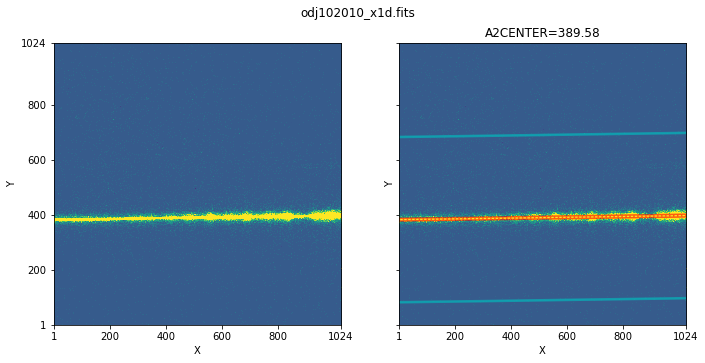

In [7]:
show_extraction_regions(x1d_filename, flt_filename)

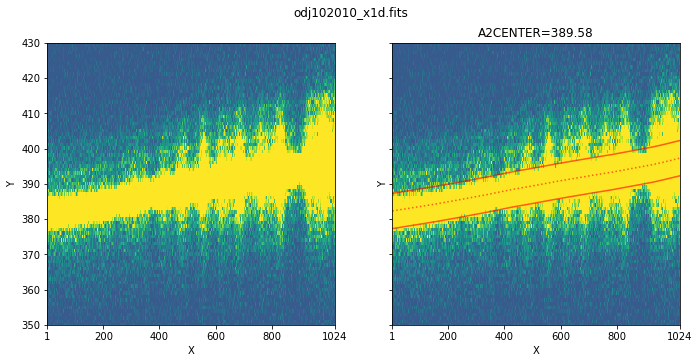

In [8]:
show_extraction_regions(x1d_filename, flt_filename,yrange=(350,430))